In [1]:
import os
# Display current working directory
print(os.getcwd())
# To make sure opencv imports .exr files
os.environ["OPENCV_IO_ENABLE_OPENEXR"] = "1"

c:\Dev\MinorProject\WDSS\jupyter_notebooks


In [2]:
# Set working directory to one level up
os.chdir('..')
print(os.getcwd())

c:\Dev\MinorProject\WDSS


# Imports

In [3]:
from config import device, Settings
from utils.image_utils import ImageUtils
import torch
import cv2
import numpy as np

## Setting up Dataset

In [4]:
# Dataset directory
dataset_path = Settings.dataset_path

rendered_img_path = os.path.join(dataset_path, 'Data\\Supermarket_Map')
base_color_path = os.path.join(dataset_path, 'Data\\Supermarket_MapBaseColor')
motion_vector_path = os.path.join(dataset_path, 'Data\\Supermarket_MapMotionVector')
world_normal_path = os.path.join(dataset_path, 'Data\\Supermarket_MapWorldNormal')
depth_path = os.path.join(dataset_path, 'Data\\Supermarket_MapSceneDepth')

grouped_paths = [(rendered_img_path, 'rendered_img'), (base_color_path, 'base_color'), 
                 (motion_vector_path, 'motion_vector'), (world_normal_path, 'world_normal'), (depth_path, 'depth')]

total_images = range(0, 121)

def get_full_path(path: str, iamge_number: int) -> str:
    # Convert image number to 4 digit string
    image_number_str = f'{iamge_number:04}'
    path += f'.{image_number_str}.exr'
    return path

get_full_path(rendered_img_path, 0)

'D:\\Download\\Datasets\\DATA_Prashant\\Data\\Supermarket_Map.0000.exr'

# Load the buffers

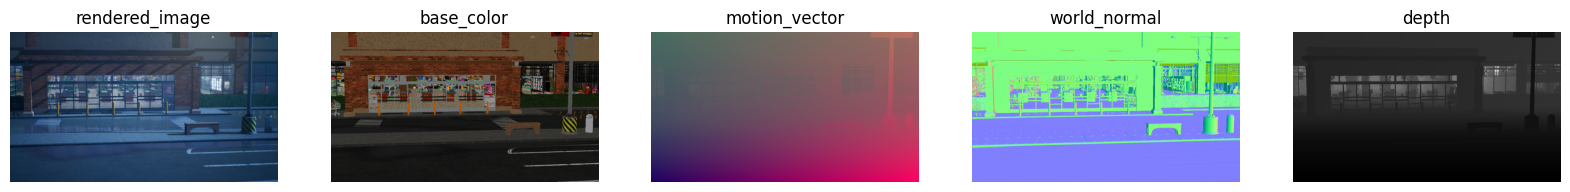

In [7]:
image_no = 52

rendered_image = ImageUtils.load_exr_image_opencv(get_full_path(rendered_img_path, image_no))
rendered_image_t = ImageUtils.opencv_image_to_tensor(rendered_image)
base_color = ImageUtils.load_exr_image_opencv(get_full_path(base_color_path, image_no))
base_color_t = ImageUtils.opencv_image_to_tensor(base_color)
motion_vector = ImageUtils.load_exr_image_opencv(get_full_path(motion_vector_path, image_no))
motion_vector_t = ImageUtils.opencv_image_to_tensor(motion_vector)
world_normal = ImageUtils.load_exr_image_opencv(get_full_path(world_normal_path, image_no))
world_normal_t = ImageUtils.opencv_image_to_tensor(world_normal)
depth = ImageUtils.load_exr_image_opencv(get_full_path(depth_path, image_no))
depth_t = ImageUtils.opencv_image_to_tensor(depth)

ImageUtils.display_images([rendered_image, base_color, motion_vector, world_normal, depth], 
                          ['rendered_image', 'base_color', 'motion_vector', 'world_normal', 'depth'])

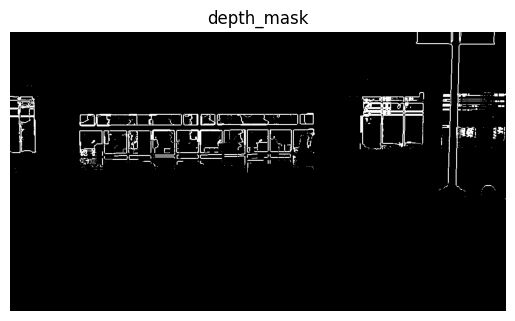

In [41]:
scale = 2

# Nearest neighbour downsample the g-buffers, to simulate LR buffers
d_base_color_t = ImageUtils.upsample(base_color_t, 1 / scale, 'nearest')
d_motion_vector_t = ImageUtils.upsample(motion_vector_t, 1 / scale, 'nearest')
d_world_normal_t = ImageUtils.upsample(world_normal_t, 1 / scale, 'nearest')
d_depth_t = ImageUtils.upsample(depth_t, 1 / scale, 'nearest')

# Bilinear upsample the LR buffers to original resolution
u_base_color_t = ImageUtils.upsample(d_base_color_t, scale)
u_motion_vector_t = ImageUtils.upsample(d_motion_vector_t, scale)
u_world_normal_t = ImageUtils.upsample(d_world_normal_t, scale)
u_depth_t = ImageUtils.upsample(d_depth_t, scale)

# Depth mask
depth_diff = torch.abs(depth_t - u_depth_t)
depth_diff = depth_diff - 0.03
# Heaviside step function
depth_mask = torch.heaviside(depth_diff, values=torch.tensor(0.0))
# Display the depth mask
ImageUtils.display_image(depth_mask, 'depth_mask')


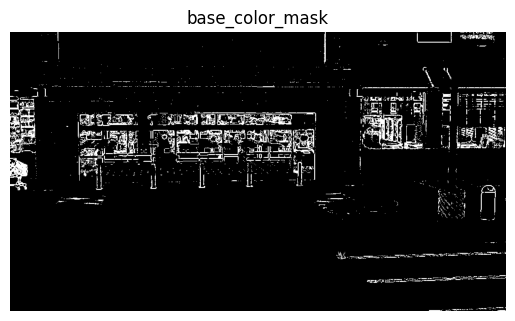

In [43]:
# Base color mask
base_color_diff = torch.abs(base_color_t - u_base_color_t)
base_color_diff = base_color_diff - 0.1
# Heaviside step function
base_color_mask = torch.heaviside(base_color_diff, values=torch.tensor(0.0))
# Convert the 3 channel mask to 1 channel
base_color_mask = base_color_mask.sum(dim=1, keepdim=True)
# Clamp the mask to 1
base_color_mask = torch.clamp(base_color_mask, max=1)
# Distribute the mask to 3 channels
base_color_mask = base_color_mask.expand(-1, 3, -1, -1)
# Display the base color mask
ImageUtils.display_image(base_color_mask, 'base_color_mask')

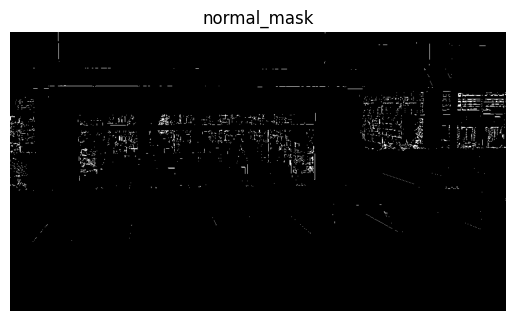

In [53]:
# Normal mask
# Perform dot product between normal and upsampled normal
normal_dotted = torch.sum(world_normal_t * u_world_normal_t, dim=1)
# Subtraction
normal_diff = 0.4 - normal_dotted
# Heaviside step function
normal_mask = torch.heaviside(normal_diff, values=torch.tensor(0.0))
# Distribute the mask to 3 channels
normal_mask = normal_mask.expand(3, -1, -1)
# Display the normal mask
ImageUtils.display_image(normal_mask, 'normal_mask')